In [1]:
import datetime as dt
from datetime import date
from datetime import datetime
from datetime import timedelta
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
import pyproj
from shapely.ops import transform
import networkx as nx
import momepy


/home/twenty/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Number of routes

In [2]:
bus_sequences = pd.read_csv('data/london/bus-sequences.csv')

In [3]:
bus_sequences

,Route,Run,Sequence,Stop_Code_LBSL,Bus_Stop_Code,Naptan_Atco,Stop_Name,Location_Easting,Location_Northing,Heading,Virtual_Bus_Stop
0,1,1,1,14456,53369,490000235Z,NEW OXFORD STREET,529998,181428,74.0,0
1,1,1,2,29844,54468,490010131WB,MUSEUM STREET,530237,181523,53.0,0
2,1,1,3,26425,54321,490000112M,KINGSWAY / HOLBORN STATION <>,530560,181433,155.0,0
3,1,1,4,BP6517,92618,490019703Z,ALDWYCH / DRURY LANE,530637,180940,201.0,0
4,1,1,5,1835,71368,490014271N,WATERLOO BRIDGE / SOUTH BANK,530890,180366,149.0,0
...,...,...,...,...,...,...,...,...,...,...,...
58100,X68,2,32,6545,73787,490010343S,NORTHCOTE ROAD / LEGACY YOUTH ZONE,532571,167119,196.0,0
58101,X68,2,33,6544,56294,490013376S,CROMWELL ROAD,532488,166822,195.0,0
58102,X68,2,34,6543,58680,490015451S,HOGARTH CRESCENT,532429,166605,198.0,0
58103,X68,2,35,6542,57633,490003793S,BEDFORD HALL,532368,166379,191.0,0


In [4]:
bus_sequences.Route.unique().shape

(793,)

# Number of stops

The reference on LBSL stop code says:

> *** KEY FIELD *** This is the alphanumeric identifier of a bus stop used by LBSL.

This number is pretty similar to the "bus stop code", so it must be "double counting" stops by distinguishing direction

In [5]:
bus_sequences.Stop_Code_LBSL.unique().shape

(20478,)

The reference on Bus stop code says:

> The area code for London is “1”.  As an example, the bus stop code for Southwark Station heading northbound is: 77293.  The NaPTAN NaptanCode for this stop is therefore 177293

Should this "double count" stops by distinguishing direction?

In [6]:
bus_sequences.Bus_Stop_Code.unique().shape

(20184,)

In [7]:
bus_sequences.Stop_Name.unique().shape

(10499,)

In [8]:
bus_sequences.Naptan_Atco.unique().shape

(20429,)

Maybe virtual bus stops need to be filtered out

In [9]:
bus_sequences[bus_sequences.Virtual_Bus_Stop == 0].Stop_Code_LBSL.unique().shape

(18919,)

In [10]:
bus_sequences[bus_sequences.Virtual_Bus_Stop == 0].Bus_Stop_Code.unique().shape

(18872,)

In [11]:
bus_sequences[bus_sequences.Virtual_Bus_Stop == 0].Stop_Name.unique().shape

(9693,)

In [12]:
bus_sequences[bus_sequences.Virtual_Bus_Stop == 0].Naptan_Atco.unique().shape

(18919,)

# Average number of stops per route

Let's accomodate all the different measures...

In [13]:
measures = [
    lambda x: x.Stop_Code_LBSL,
    lambda x: x.Bus_Stop_Code,
    lambda x: x.Stop_Name,
    lambda x: x.Naptan_Atco
]

In [14]:
for measure in measures:
    print(measure(bus_sequences.groupby('Route')).count().mean())

73.27238335435057
73.2673392181589
73.27238335435057
73.27112232030265


<AxesSubplot:xlabel='Route'>

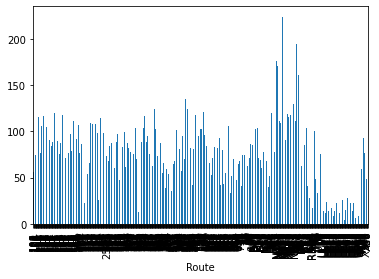

In [15]:
bus_sequences.groupby('Route').Stop_Code_LBSL.count().plot.bar()

# Average route length

The CRS is British National Grid (27700), which is in metres

In [16]:
c = bus_sequences[['Location_Easting', 'Location_Northing']].apply(Point, axis=1)

In [17]:
c

0        POINT (529998 181428)
1        POINT (530237 181523)
2        POINT (530560 181433)
3        POINT (530637 180940)
4        POINT (530890 180366)
                 ...          
58100    POINT (532571 167119)
58101    POINT (532488 166822)
58102    POINT (532429 166605)
58103    POINT (532368 166379)
58104    POINT (532236 166185)
Length: 58105, dtype: object

In [18]:
bus_sequences['geometry'] = c

In [19]:
def to_linestring(x):
    geom = x.geometry
    if len(geom) == 1:
        return None
    return LineString(geom.reset_index(drop=True))

# For every route and run...
linestring_by_runs = bus_sequences.groupby(['Route', 'Run']).apply(to_linestring)
linestring_by_runs

Route  Run
1      1      LINESTRING (529998 181428, 530237 181523, 5305...
       2      LINESTRING (535467 179451, 535430 179135, 5357...
100    1      LINESTRING (532026 181450, 532062 181569, 5322...
       2      LINESTRING (534799 180910, 534821 180706, 5348...
101    1      LINESTRING (540542 188400, 540584 188379, 5405...
                                    ...                        
X140   2      LINESTRING (515288 188108, 514225 186352, 5137...
X26    1      LINESTRING (532220 166139, 532748 165706, 5287...
       2      LINESTRING (507514 175845, 509614 175382, 5157...
X68    1      LINESTRING (532250 166167, 532365 166417, 5323...
       2      LINESTRING (530033 182042, 530289 181907, 5304...
Length: 1702, dtype: object

In [22]:
route_lengths = linestring_by_runs.dropna().apply(lambda x: x.length)
route_lengths

Route  Run
1      1       8247.834640
       2       8552.044646
100    1       5753.782624
       2       5209.819719
101    1      10804.467542
                  ...     
X140   2      14821.371159
X26    1      30937.166032
       2      31094.572755
X68    1      17299.840987
       2      17573.124391
Length: 1600, dtype: float64

In [23]:
# Global Average route length in metres
route_lengths.mean()

12122.48348203137

<AxesSubplot:ylabel='Frequency'>

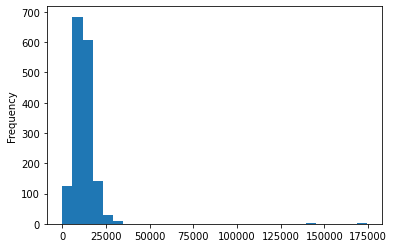

In [24]:
route_lengths.plot.hist(bins=30)

# Average distance between stops

In [25]:
# TODO: copied from delhi.ipynb
def calc_distances(x):
    '''
    input: [(float, float)]
        a list of coordinates
    output: [float]
        the distances between each coordinates
    '''
    return [Point(a).distance(Point(b)) for a, b in zip(x, x[1:])]

In [26]:
def f(x):
    geom = x.geometry
    if len(geom) == 1:
        return None
    return calc_distances(geom.reset_index(drop=True))

route_stop_dists = bus_sequences.groupby(['Route', 'Run']).apply(f)
route_stop_dists

Route  Run
1      1      [257.1886467167631, 335.3043393694749, 498.976...
       2      [318.15876539866065, 311.8236681203016, 68.680...
100    1      [124.32618388738553, 200.0024999843752, 376.22...
       2      [205.1828452868319, 320.30610359467084, 141.99...
101    1      [46.95742752749558, 208.83725721240452, 345.85...
                                    ...                        
X140   2      [2052.682391408861, 884.7762428998645, 1156.41...
X26    1      [682.8418557762844, 4148.835981332595, 534.899...
       2      [2150.434607236407, 7529.286353964763, 2696.28...
X68    1      [275.1817581163403, 259.5149321330085, 351.410...
       2      [289.4149270511112, 206.4654934849889, 343.209...
Length: 1702, dtype: object

In [27]:
route_avg_stop_dists = route_stop_dists.dropna().apply(np.mean)
route_avg_stop_dists

Route  Run
1      1       305.475357
       2       316.742394
100    1       250.164462
       2       248.086653
101    1       251.266687
                 ...     
X140   2      1235.114263
X26    1      2379.782002
       2      2391.890212
X68    1       540.620031
       2       502.089268
Length: 1600, dtype: float64

In [28]:
# Global average distance between stops meters
route_avg_stop_dists.mean()

536.8036534744423

<AxesSubplot:>

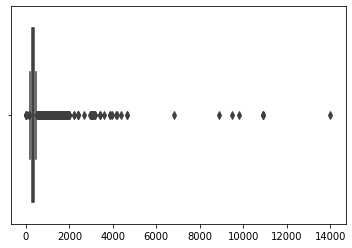

In [29]:
sns.boxplot(x=route_avg_stop_dists)

<AxesSubplot:>

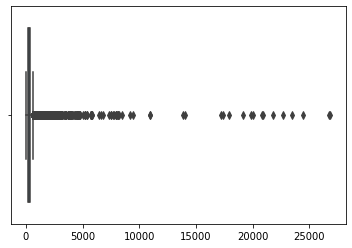

In [30]:
# The individual distances between every stops in every route
sns.boxplot(x=route_stop_dists.explode().values.astype(float))

# Median bus speed

I don't have static time data for London buses (at least, not in this dataset)

But tbf, in the delhi dataset, the time data is unreliable too, as it is the scheduled times not the actual times

# Network diameter

In [50]:
route_stop_coords = bus_sequences.groupby(['Route', 'Run'])
route_stop_coords

In [51]:
def f(x):
    return [(n, x, y) for n, x, y in zip(x.Stop_Code_LBSL, x.Location_Easting, x.Location_Northing)]
    
route_stop_coords = route_stop_coords.apply(f)
route_stop_coords

Route  Run
1      1      [(14456, 529998, 181428), (29844, 530237, 1815...
       2      [(BP2391, 535467, 179451), (25923, 535430, 179...
100    1      [(BP5593, 532026, 181450), (BP5594, 532062, 18...
       2      [(BP2340, 534799, 180910), (LE108, 534821, 180...
101    1      [(34050, 540542, 188400), (15555, 540584, 1883...
                                    ...                        
X140   2      [(R0842, 515288, 188108), (26472, 514225, 1863...
X26    1      [(BP6117, 532220, 166139), (BP2129, 532748, 16...
       2      [(BP5117, 507514, 175845), (35287, 509614, 175...
X68    1      [(BP6115, 532250, 166167), (6564, 532365, 1664...
       2      [(33925, 530033, 182042), (8437, 530289, 18190...
Length: 1702, dtype: object

In [62]:
exploded = route_stop_coords.reset_index(drop=True).explode()
exploded

0        (14456, 529998, 181428)
0        (29844, 530237, 181523)
0        (26425, 530560, 181433)
0       (BP6517, 530637, 180940)
0         (1835, 530890, 180366)
                  ...           
1701      (6545, 532571, 167119)
1701      (6544, 532488, 166822)
1701      (6543, 532429, 166605)
1701      (6542, 532368, 166379)
1701    (BP6119, 532236, 166185)
Length: 58105, dtype: object

In [64]:
df = pd.DataFrame()
df['names'] = exploded.map(lambda x: x[0])
df['x'] = exploded.map(lambda x: x[1])
df['y'] = exploded.map(lambda x: x[2])

In [65]:
g = nx.from_dict_of_lists(df.to_dict())

In [66]:
nx.algorithms.distance_measures.diameter(g)

2

# Network density

In [67]:
nx.classes.function.density(g)

0.003514931229606377

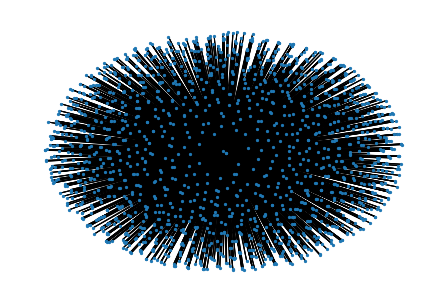

In [69]:
nx.draw(g, node_size=5)